In [2]:
import os
import json
import logging

#Libraries from PyTorch
from torchvision.io import read_image
import torch  # PyTorch's core library for building and training deep learning models
import torch.nn as nn  # Import the neural network module from PyTorch
import torch.optim as optim  # Import optimization algorithms such as SGD, Adam
import torch.nn.functional as F  # Import functional utilities like activation functions
from torch.utils.data import Dataset, DataLoader, random_split # DataLoader for batching, and random_split for splitting data
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights

#Libraries for data processing and visualization
from matplotlib import pyplot as plt # For plotting graphs
import matplotlib.patches as patches # For bounding boxes
import numpy as np # For numerical operations
from PIL import Image
from collections import defaultdict

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # For evaluation metrics

plt.rcParams['figure.figsize'] = (15, 15)



In [2]:
image_ids_annotations = defaultdict(list)

# Load annotations
path = './annotations/instances_train2017.json'
file = open(path)
anns = json.load(file)
image_ids = list()

# Add into datastructure
for ann in anns['annotations']:
    image_id = ann['image_id'] # Are integers
    image_ids.append(image_id)
    image_ids_annotations[image_id].append(ann)


In [3]:
# Inicialization of the values per categorie  
catergory_id_count = dict()
for ann in anns['categories']:
    catergory_id_count[ann['id']] = 0

# Identification of the repetion per category 
for ann in anns['annotations']:
    category_id = ann['category_id']
    catergory_id_count[category_id] += 1

print(catergory_id_count)

{1: 262465, 2: 7113, 3: 43867, 4: 8725, 5: 5135, 6: 6069, 7: 4571, 8: 9973, 9: 10759, 10: 12884, 11: 1865, 13: 1983, 14: 1285, 15: 9838, 16: 10806, 17: 4768, 18: 5508, 19: 6587, 20: 9509, 21: 8147, 22: 5513, 23: 1294, 24: 5303, 25: 5131, 27: 8720, 28: 11431, 31: 12354, 32: 6496, 33: 6192, 34: 2682, 35: 6646, 36: 2685, 37: 6347, 38: 9076, 39: 3276, 40: 3747, 41: 5543, 42: 6126, 43: 4812, 44: 24342, 46: 7913, 47: 20650, 48: 5479, 49: 7770, 50: 6165, 51: 14358, 52: 9458, 53: 5851, 54: 4373, 55: 6399, 56: 7308, 57: 7852, 58: 2918, 59: 5821, 60: 7179, 61: 6353, 62: 38491, 63: 5779, 64: 8652, 65: 4192, 67: 15714, 70: 4157, 72: 5805, 73: 4970, 74: 2262, 75: 5703, 76: 2855, 77: 6434, 78: 1673, 79: 3334, 80: 225, 81: 5610, 82: 2637, 84: 24715, 85: 6334, 86: 6613, 87: 1481, 88: 4793, 89: 198, 90: 1954}


In [4]:
# Get mapping category_id to category name
catergory_id_to_name = dict()
for ann in anns['categories']:
    catergory_id_to_name[ann['id']] = ann['name']

print(catergory_id_to_name)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

[262465, 7113, 43867, 8725, 5135, 6069, 4571, 9973, 10759, 12884, 1865, 1983, 1285, 9838, 10806, 4768, 5508, 6587, 9509, 8147, 5513, 1294, 5303, 5131, 8720, 11431, 12354, 6496, 6192, 2682, 6646, 2685, 6347, 9076, 3276, 3747, 5543, 6126, 4812, 24342, 7913, 20650, 5479, 7770, 6165, 14358, 9458, 5851, 4373, 6399, 7308, 7852, 2918, 5821, 7179, 6353, 38491, 5779, 8652, 4192, 15714, 4157, 5805, 4970, 2262, 5703, 2855, 6434, 1673, 3334, 225, 5610, 2637, 24715, 6334, 6613, 1481, 4793, 198, 1954]
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana'

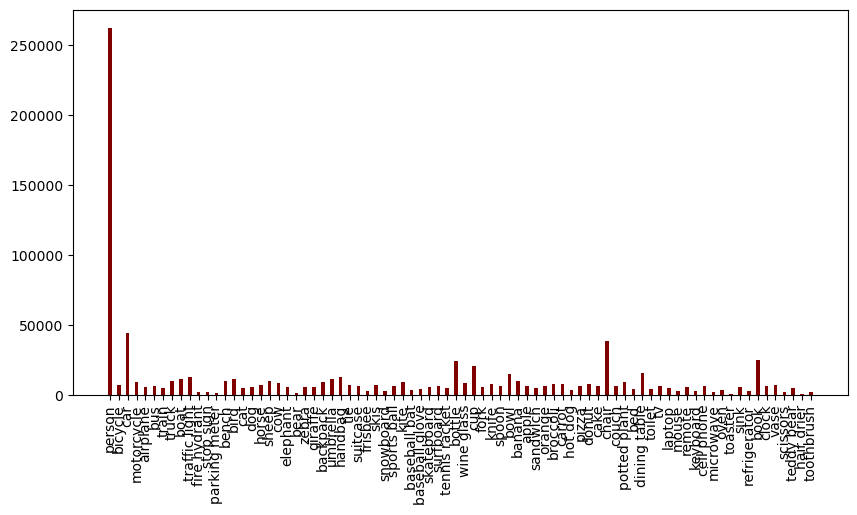

In [5]:
# Creation of the Histogram 
values = list(catergory_id_count.values())
names = list(catergory_id_to_name.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(names, values, color ='maroon', 
        width = 0.4)
plt.xticks(rotation=90)

print(values)
print(names)

In [6]:
# Dataset loader for COCO
class COCOMultiLabelDataset(Dataset):
    def __init__(self, img_dir, ann_file, image_ids, transform=None): # Initialize the dataset with the images directory, the annotation file and transformations
        self.coco = ann_file # Load COCO annotations from the provided annotations file
        self.img_dir = img_dir  # Directory containing the images
        self.transform = transform  # Transformations (e.g. resizing, cropping, ...) to apply to each image
        self.ids = image_ids  # Get a list of image IDs from the dataset

    # Return the number of images in the dataset
    def __len__(self): 
        return len(self.ids)

    # Get an image and its corresponding labels, based on an index
    def __getitem__(self, index):
        img_id = self.ids[index] # Get the image ID corresponding to the given index
        path = "0" * (12 - len(str(img_id))) +str(img_id) + ".jpg"
        img_path = os.path.join(self.img_dir, path) # Create the full path to the image

        # Load the image using PIL and convert it to RGB format
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None: # If transformation is given, apply it to the image
            img = self.transform(img)

        # Get multi-label annotations
        anns = self.coco[img_id]
        labels = torch.zeros(90)  # Initialize a tensor of zeros for multi label classification (80 different classes in COCO)

        # Iterate through each annotation to set the corresponding labels
        for ann in anns:
            category_id = ann['category_id'] # Extract the category ID from the annotation
            labels[category_id-1] = 1.0

        return img, labels # Return the transformed image and its multi-label tensor

In [7]:
# Resizing of Images and Normalization
img_dir = './train2017'

img_transforms = transforms.Compose([
        transforms.Resize((224, 224)), # Resize Images to a size of 24*24 Pixels
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]) # Normalization using standard values for RGB images
    ])

train_data = COCOMultiLabelDataset(img_dir=img_dir,
                                   ann_file=image_ids_annotations,
                                   transform=img_transforms,
                                   image_ids=image_ids) 


In [8]:
train_size = int(0.8 * len(train_data))  # 90% of the data will be used for training
val_size = int(0.1 * len(train_data))  # 10% of the data  will be used for validation
test_size = len(train_data) - train_size - val_size # Remaining data will be used for test

train_data, val_data, test_data = random_split(train_data, [train_size, val_size, test_size]) # Divide dataset into training, validation and test splits. 

In [9]:
# DataLoader for the training set
train_loader = DataLoader(
    train_data,  # The training dataset
    batch_size=16,  # Number of samples per batch during training
    shuffle=True  # Shuffle the data at the start of every epoch for better generalization
)

# DataLoader for the validation set
val_loader = DataLoader(
    val_data,  # The validation dataset
    batch_size=16,  # Same batch size as training
    shuffle=False  # No need to shuffle validation data
)

# DataLoader for the validation set
test_loader = DataLoader(
    test_data,  # The validation dataset
    batch_size=16,  # Same batch size as training
    shuffle=False  # No need to shuffle validation data
)

# Printing of the sizes of the datasets
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {len(test_data)}")

Training set size: 688000
Validation set size: 86000
Test set size: 86001


In [10]:
# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if CUDA is available and output the result (True if a GPU is available, False otherwise)
torch.cuda.is_available()

False

In [11]:

# Define the OOP Model class inheriting from nn.Module
class CustomMLP(nn.Module):
    def __init__(self):
        super(CustomMLP, self).__init__()  # Call the parent class's constructor

        #First Layer
        self.fc1 = nn.Linear(224 * 224 *3 ,512) # Fully conected layer that takes 224*224*3Pixel input and maps it to 512 units.
        #Second Layer
        self.fc2 = nn.Linear(512,512) # Another fully conected layer that keeps the 512 units.
        #Output layer
        self.fc3 = nn.Linear(512,90) # Output layer that maps the 512 units to 80 units.

        # Define the activation function - ReLU (Rectified Linear Unit) - Sigmoid
        self.relu = nn.ReLU() # ReLU intriduces non-linearity after each layer
        self.sigmoid = nn.Sigmoid()


    # Define the forward pass (how data flows through the network)
    def forward(self, x):
        x = x.view(-1, 224 * 224 * 3) # Flatten the input tensor from 224*224*3 to 150528

        x = F.relu(self.fc1(x)) # Pass data through the first layer and apply ReLU activation 

        x = F.relu(self.fc2(x)) # Pass data through the second layer and apply ReLU activation

        return self.sigmoid(self.fc3(x)) # Pass data through the output layer and apply Sigmoid activation

In [12]:
# Instantiate the OOP model
oop_model = CustomMLP().to(device)  # Move the model to the device (GPU/CPU)

In [13]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
oop_model.to(device)

CustomMLP(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=90, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [14]:
# Define Loss function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(oop_model.parameters(), lr=0.001)

In [15]:
# Modified training loop to return average training loss for each epoch
def train_model(model, device, train_loader, optimizer, loss_fn):
    model.train()  # Set the model to training mode (activates dropout and batch normalization)
    running_loss = 0.0  # Initialize a variable to keep track of the cumulative loss for the epoch

    # Iterate over batches of data from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data and target to the appropriate device (GPU/CPU)

        # Zero the gradients for the optimizer
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing data through the model
        output = model(data)

        # Calculate the loss between the predicted outputs and the true labels
        loss = loss_fn(output, target)
        print("Loss:"+str(loss.item()))
        # Backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()

        # Update the model weights based on the computed gradients
        optimizer.step()

        running_loss += loss.item()  # Accumulate the loss for the current batch

    # Compute the average loss for the entire epoch
    avg_train_loss = running_loss / len(train_loader)
    return avg_train_loss  # Return the average training loss for this epoch


In [16]:
train_loss = train_model(oop_model, device, train_loader, optimizer, loss_fn)

Loss:16.03548812866211
Loss:15.844130516052246
Loss:20.791780471801758
Loss:14.532450675964355
Loss:16.823270797729492
Loss:18.318401336669922
Loss:17.637866973876953
Loss:21.40418243408203
Loss:16.587228775024414
Loss:16.480730056762695
Loss:18.018152236938477
Loss:21.173126220703125
Loss:18.562875747680664
Loss:21.246671676635742
Loss:17.644798278808594
Loss:20.410139083862305
Loss:15.325800895690918
Loss:17.412578582763672
Loss:21.351970672607422
Loss:20.461362838745117
Loss:16.048891067504883
Loss:17.89913558959961
Loss:14.441326141357422
Loss:20.687227249145508
Loss:18.173513412475586
Loss:14.855514526367188
Loss:16.153671264648438
Loss:21.216068267822266
Loss:16.196317672729492


KeyboardInterrupt: 

In [1]:
# Validation function
def validate_model(model, device, val_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode (disables dropout and batch normalization)
    val_loss = 0.0  # Variable to accumulate validation loss

    # Iterate over batches of data from the training set
    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)  # Move data and target to the appropriate device (GPU/CPU)

        # Zero the gradients for the optimizer
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing data through the model
        output = model(data)

        # Calculate the loss between the predicted outputs and the true labels
        val_loss = loss_fn(output, target)
        print("Loss:"+str(val_loss.item()))

        running_loss += val_loss.item()  # Accumulate the loss for the current batch

    # Compute the average loss for the entire epoch
    avg_val_loss = running_loss / len(val_loader)
    return avg_val_loss  # Return the average training loss for this epoch


In [19]:
# Testing function
def test_model(model, device, test_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode (disables dropout and batch normalization)
    test_loss = 0.0  # Variable to accumulate total test loss
    correct = 0  # Counter for the number of correct predictions

    with torch.no_grad():  # Disable gradient computation during testing for efficiency
        for data, target in test_loader:  # Iterate over the test dataset
            data, target = data.to(device), target.to(device)  # Move data and target to the appropriate device
            output = model(data)  # Forward pass: compute predicted outputs by passing data through the model
            test_loss += loss_fn(output, target).item()  # Accumulate test loss

            # Get predictions by finding the index of the maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)  # Get the predicted class labels
            correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions

    # Compute average loss and accuracy for the test set
    test_loss /= len(test_loader)  # Average test loss
    accuracy = 100. * correct / len(test_loader.dataset)  # Accuracy as a percentage

    # Print test loss and accuracy
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    return test_loss, accuracy  # Return average test loss and accuracy

In [20]:
# Training and validation loop with validation set
def train_and_evaluate(model, device, train_loader, val_loader, test_loader, optimizer, loss_fn, epochs=5):
    # Lists to store losses and accuracies
    train_losses = []  # To track training losses over epochs
    val_losses = []    # To track validation losses over epochs
    val_accuracies = []  # To track validation accuracies over epochs
    test_losses = []   # To track test losses after training
    test_accuracies = []  # To track test accuracies after training

    # Loop over the number of epochs
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        logging.debug(f"\nEpoch {epoch + 1}/{epochs}")

        # Train the model and get training loss
        train_loss = train_model(model, device, train_loader, optimizer, loss_fn)  # Call the training function
        train_losses.append(train_loss)  # Store the training loss

        # Validate the model and get validation loss and accuracy
        val_loss, val_accuracy = validate_model(model, device, val_loader, loss_fn)  # Call the validation function
        val_losses.append(val_loss)  # Store the validation loss
        val_accuracies.append(val_accuracy)  # Store the validation accuracy

        # Test the model and get test loss and accuracy (only for test set evaluation)
        test_loss, test_accuracy = test_model(model, device, test_loader, loss_fn)  # Call the testing function
        test_losses.append(test_loss)  # Store the test loss
        test_accuracies.append(test_accuracy)  # Store the test accuracy

        # Print training and validation results for the current epoch
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        logging.debug(f"Training Loss: {train_loss:.4f}")
        logging.debug(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        logging.debug(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        torch.save(oop_model.state_dict(),"model_state_epoch_"+str(epoch)+".pt")

    # Return all recorded losses and accuracies for further analysis
    return train_losses, val_losses, val_accuracies, test_losses, test_accuracies


In [21]:
# Example usage for 5 epochs (replace train_loader, val_loader, and test_loader with actual loaders)
epochs = 3  # Set the number of epochs for training

logging.basicConfig(filename='train_validation_losses.log', level=logging.DEBUG)


In [22]:

# Track training, validation, and test results
train_losses, val_losses, val_accuracies, test_losses, test_accuracies = train_and_evaluate(
    oop_model,  # The model to be trained and evaluated
    device,  # The device (CPU or GPU) where the model will run
    train_loader,  # DataLoader for training data
    val_loader,  # DataLoader for validation data
    test_loader,  # DataLoader for test data
    optimizer,  # Optimizer to update model weights
    loss_fn,  # Loss function to compute the loss
    epochs=epochs  # Number of epochs to train for
)

# After training, you can analyze the recorded losses and accuracies


Epoch 1/3
Loss:17.99378204345703
Loss:20.333431243896484
Loss:20.191728591918945
Loss:21.962560653686523
Loss:18.254846572875977
Loss:20.68954849243164
Loss:17.605403900146484
Loss:17.806861877441406
Loss:19.568359375
Loss:16.739517211914062
Loss:13.086273193359375
Loss:15.72982120513916
Loss:16.138654708862305
Loss:15.99570369720459
Loss:18.101688385009766
Loss:15.169291496276855
Loss:16.277036666870117
Loss:15.313118934631348
Loss:17.732866287231445
Loss:13.666228294372559
Loss:16.014060974121094
Loss:19.85860824584961
Loss:15.821810722351074
Loss:12.824548721313477
Loss:18.696962356567383
Loss:17.11513900756836
Loss:17.945751190185547
Loss:15.291810989379883
Loss:16.623001098632812
Loss:20.047016143798828
Loss:20.013797760009766
Loss:21.524002075195312
Loss:19.657760620117188
Loss:18.318143844604492
Loss:18.054542541503906
Loss:15.230950355529785
Loss:20.05561065673828
Loss:17.564075469970703
Loss:15.14822006225586
Loss:24.08018684387207
Loss:15.16344928741455
Loss:14.3183450698852

RuntimeError: shape '[16, 1]' is invalid for input of size 1440

In [59]:
logging.debug('This is a debug message')

In [54]:

logging.basicConfig(filename='example.log', level=logging.DEBUG)